In [1]:
%matplotlib inline

In [2]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import numpy as np
import sys
from scipy import stats
import netCDF4 as nc
from pathlib import Path
import arviz as az
# if you get a ModuleNotFoundError,
# check if you did "pip install -e ." in the project root
import icounter.models as models
import icounter.fourier as fourier
import icounter.datahandler as dh
import icounter.estimator as est
import settings as s
plt.rcParams["font.size"] = 10
plt.rcParams["figure.figsize"] = 12,8

print(pm.__version__)

3.7


In [3]:
data_dir = Path("/home/mengel/data/20190306_IsimipDetrend/")
s.output_dir = Path(data_dir) / "output" / "isi-cfact"

variable = "tas"

# get the predictor, a smoothed version of global mean temperature.
ncg = nc.Dataset("data/gswp3_ssa_gmt.nc4","r")
gmt = np.squeeze(ncg.variables["tas"][:])
ncg.close()

# get regional climate variable data, here surface air temperature "tas"
source_file = variable+"_watch+wfdei_sub80.nc4"
ncf = nc.Dataset("data/tas_watch+wfdei_sub80.nc4", "r")
nct = ncf.variables["time"]

In [4]:
# Choose from one of the few grid cells in the sample datasets.
# lat 49.75, lon 20.25, a region in South Poland, south of Krakow
i=1
j=5
ncf.variables["lat"][i].data, ncf.variables["lon"][j].data

(array(49.75), array(20.25))

In [5]:
# read data and time into a specific dataframe that is understood by icounter.
data = ncf.variables[variable][:, i, j]
df, datamin, scale = dh.create_dataframe(nct[:],nct.units, data[:],
                                         gmt,variable)

In [6]:
# dh.create_dataframe produces a calender and a scaled time axis and variables.
# this helps for efficient sampling
df.head(10)

,ds,t,y,y_scaled,gmt,gmt_scaled
0,1901-01-01,0.000000,266.407013,0.324912,287.531150,0.012504
1,1901-01-02,0.000024,264.742004,0.291179,287.531092,0.012447
2,1901-01-03,0.000047,266.690002,0.330646,287.531034,0.012390
3,1901-01-04,0.000071,269.362000,0.384781,287.530975,0.012332
4,1901-01-05,0.000094,268.075989,0.358726,287.530917,0.012275
5,1901-01-06,0.000118,263.984009,0.275822,287.530859,0.012218
6,1901-01-07,0.000142,262.084015,0.237328,287.530800,0.012161
7,1901-01-08,0.000165,262.903992,0.253941,287.530742,0.012104
8,1901-01-09,0.000189,263.533997,0.266704,287.530684,0.012047
9,1901-01-10,0.000212,261.364990,0.222760,287.530626,0.011990


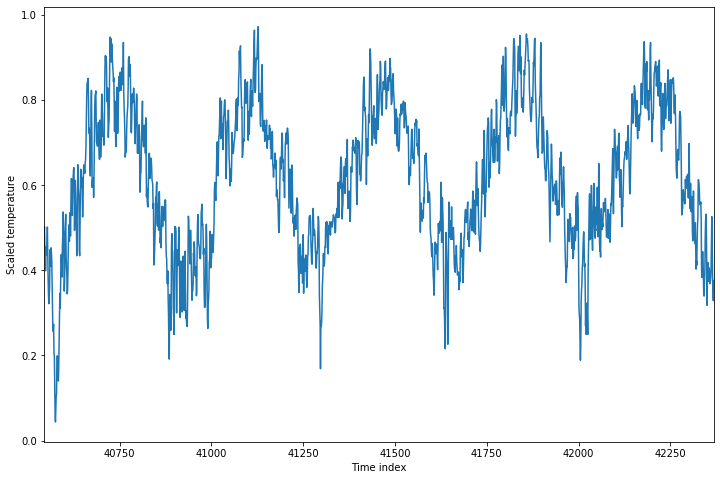

In [7]:
# the variable we would like to build a counterfactual of,
# in its scaled form, last 5 years only
last_5_year_start = len(df)-5*365
df.loc[last_5_year_start:,"y_scaled"].plot()
plt.ylabel("Scaled temperature")
l = plt.xlabel("Time index")

In [8]:
# select with how many fourier modes we would like to model the yearly cycle
# modes=3 means three sine modes and three cosine modes, so six modes
modes = 3
# decide to pick only every subset'th datapoint, to speed up sampling 
# in exchange for preciseness
subset = 10

# get the data we actually provide to the pymc3 sampler
# for data with missing values, only the valid values are picked here.
# this can be less than selected by subset.
df_valid, x_fourier_valid, regressor = dh.get_valid_subset(df, modes, subset)

# Choose your statistical model, for tas this is the Normal distribution model
# with influence of GMT modelled through a shift in mu, the central value of the distribution.
model = models.Normal(modes=modes)
smodel = model.setup(regressor, x_fourier_valid, df_valid["y_scaled"])

4237 data points used from originally 42369 datapoints.
Using Normal distribution model.


In [9]:
# the actual sampling step to estimate all model parameter at once
# this is the computationally expensive part of the program
with smodel:
    trace = pm.sample(draws=2000)
    data = az.from_pymc3(trace=trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_trend, beta_yearly, sigma, intercept, slope]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:22<00:00, 226.81draws/s]


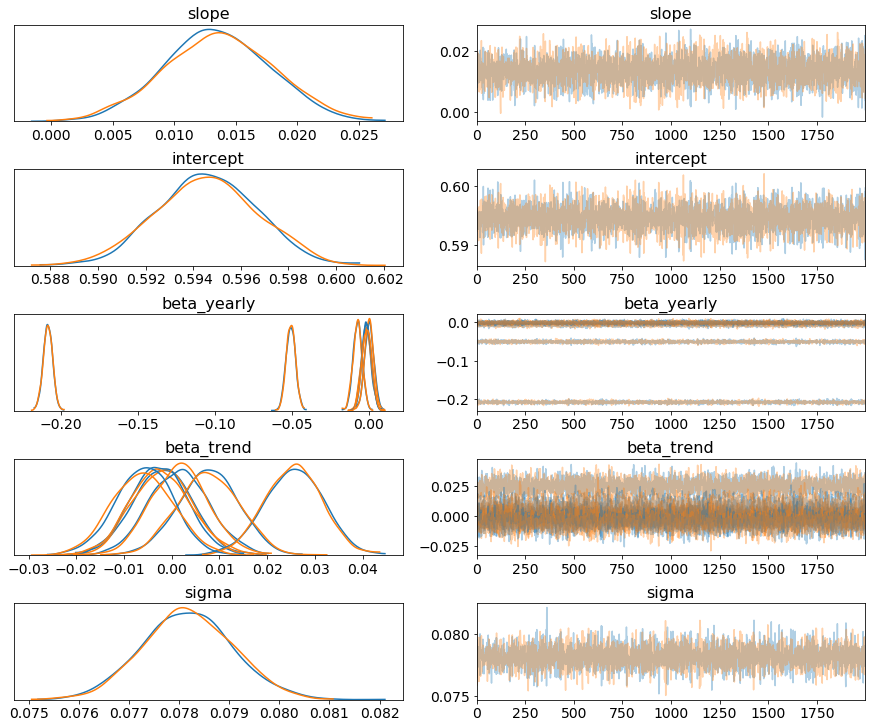

In [10]:
# the estimated parameter distribution given the data.
# for our prior assumptions for the Normal model, see models.py
l = pm.traceplot(data, compact=True)

100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


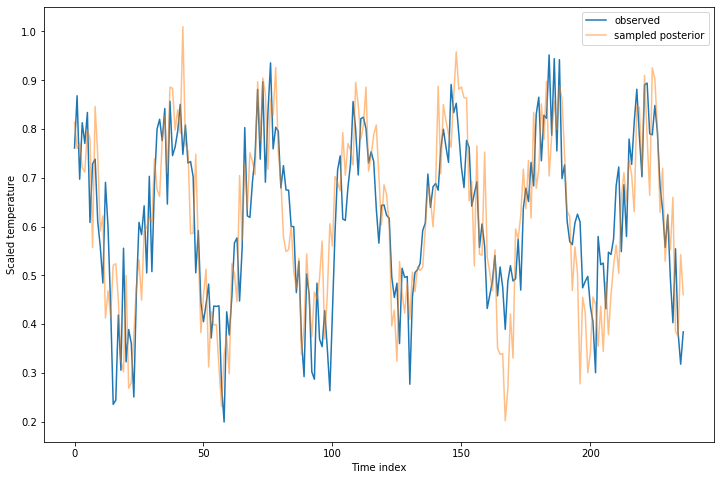

In [11]:
# as a quick test, 
# check how well the model can predict the change in variable tas
# Only every 10th value is shown here.
ppc = pm.sample_posterior_predictive(trace,samples=1,model=smodel
                        )
# approximately last 6 years
p = plt.plot(df["y_scaled"].values[4000*subset::subset],alpha=1., label="observed")
p = plt.plot(ppc["obs"][0,4000:],alpha=.5, label="sampled posterior")
plt.legend()
plt.ylabel("Scaled temperature")
l = plt.xlabel("Time index")

In [12]:
# Build the counterfactual from the information we gained on parameters,
# saved in the trace
s.variable="tas"
s.modes=3
estimator = est.estimator(s)
# we here use the original dataframe, so we have every timestep
cfact_scaled = estimator.estimate_timeseries(df, trace, datamin, scale)
# bring together with other data
df_with_cfact = dh.add_cfact_to_df(df, cfact_scaled, datamin, scale, s.variable)

Using Normal distribution model.


In [13]:
df_with_cfact.head(10)

,ds,t,y,y_scaled,gmt,gmt_scaled,cfact_scaled,cfact
0,1901-01-01,0.000000,266.407013,0.324912,287.531150,0.012504,0.325285,266.425415
1,1901-01-02,0.000024,264.742004,0.291179,287.531092,0.012447,0.291532,264.759430
2,1901-01-03,0.000047,266.690002,0.330646,287.531034,0.012390,0.330978,266.706421
3,1901-01-04,0.000071,269.362000,0.384781,287.530975,0.012332,0.385093,269.377411
4,1901-01-05,0.000094,268.075989,0.358726,287.530917,0.012275,0.359017,268.090393
5,1901-01-06,0.000118,263.984009,0.275822,287.530859,0.012218,0.276093,263.997375
6,1901-01-07,0.000142,262.084015,0.237328,287.530800,0.012161,0.237578,262.096375
7,1901-01-08,0.000165,262.903992,0.253941,287.530742,0.012104,0.254170,262.915344
8,1901-01-09,0.000189,263.533997,0.266704,287.530684,0.012047,0.266914,263.544312
9,1901-01-10,0.000212,261.364990,0.222760,287.530626,0.011990,0.222948,261.374298


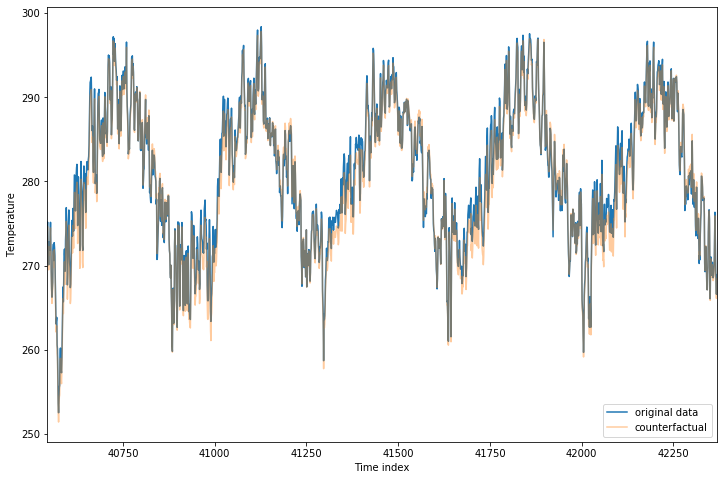

In [14]:
# Original versus counterfactual
# Most visibly, early-spring temperatures are adjusted downwards in this example.
df_with_cfact.loc[last_5_year_start:,"y"].plot(label="original data")
df_with_cfact.loc[last_5_year_start:,"cfact"].plot(label="counterfactual",alpha=0.4)
plt.legend()
plt.ylabel("Temperature")
l = plt.xlabel("Time index")